In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display
import networkx as nx

In [2]:
%matplotlib inline

In [3]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]

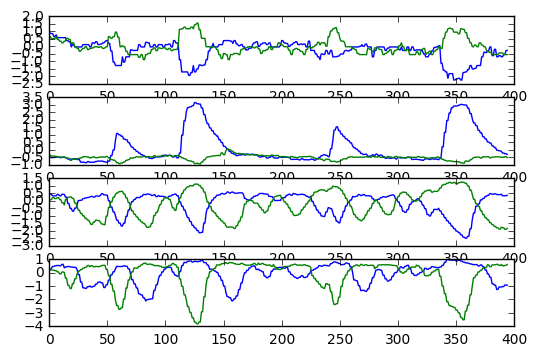

In [71]:
fly = flylist[-9]
snum =4
idx = fly.block_data['common','idx','cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
plt.subplot(4,1,1)
plt.plot(fly.normed_signals['left','amp'][idx])
plt.plot(fly.normed_signals['right','amp'][idx])
plt.subplot(4,1,2)
plt.plot(fly.normed_signals['left','i1'][idx])
plt.plot(fly.normed_signals['right','i1'][idx])
plt.subplot(4,1,3)
plt.plot(fly.normed_signals['left','iii3'][idx])
plt.plot(fly.normed_signals['right','iii3'][idx])
plt.subplot(4,1,4)
plt.plot(fly.normed_signals['left','b3'][idx])
plt.plot(fly.normed_signals['right','b3'][idx])

In [73]:
reload(lpf)

<module 'local_project_functions' from 'local_project_functions.py'>

In [766]:
TAU_ON_F = 0.01595905
TAU_OFF_F = 0.23594343
times = np.arange(0,90/0.02)*0.02
fast_kernel = lpf.make_single_kernel(times,TAU_ON_F,TAU_OFF_F)



In [899]:
(1-(0.08*2))/2

0.42

In [913]:
TAU_ON_S = 0.0155905
TAU_OFF_S = 0.23594343
times = np.arange(0,90/0.02)*0.02
slow_kernel = lpf.make_single_kernel(times,TAU_ON_S,TAU_OFF_S)

state_table= [[1,1],
              [0,1],
              [1,0],
              [0,0]]

tmtrx_coup = [[0.12,    0.38,    0.38,     0.12],
              [0.08,    0.76,    0.08,     0.08],
              [0.08,    0.08,    0.76,     0.08],
              [0.12,    0.38,    0.38,     0.12]]


# tmtrx_coup = [[0.76,    0.08,    0.08,     0.08],
#               [0.42,    0.08,    0.08,     0.42],
#               [0.42,    0.08,    0.08,     0.42],
#               [0.08,    0.08,    0.08,     0.76]]

tmtrx_coup = np.array(tmtrx_coup).T
print(np.sum(tmtrx_coup,axis = 0))

# tmtrx_ind = [[0.76,    0.08,    0.08,     0.08],
#              [0.08,    0.76,    0.08,     0.08],
#              [0.08,    0.08,    0.76,     0.08],
#              [0.32,    0.32,    0.32,     0.04]]

tmtrx_ind = [[0.70,    0.14,    0.14,     0.02],
             [0.30,    0.66,    0.02,     0.02],
             [0.30,    0.02,    0.66,     0.02],
             [0.97,    0.01,    0.01,     0.01]]


tmtrx_ind = np.array(tmtrx_ind).T
print(np.sum(tmtrx_ind,axis = 0))

state_table = np.array(state_table)

## simulate a coupled network
state_list_coup = [[0,1]]
for i in range(len(times)):
    state_list_coup.append(lpf.next_state(state_list_coup[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_coup).T)
state_list_coup = np.array(state_list_coup)

## simulate an independent network
state_list_ind = [[0,1]]
for i in range(len(times)):
    state_list_ind.append(lpf.next_state(state_list_ind[-1],
                                     state_table=state_table,
                                     tmtrx = tmtrx_ind).T)
state_list_ind = np.array(state_list_ind)

## break out the signals
cell_A_ind = np.array([state_list_ind[:,0]])
cell_B_ind = np.array([state_list_ind[:,1]])
cell_A_coup = np.array([state_list_coup[:,0]])
cell_B_coup = np.array([state_list_coup[:,1]])

cell_A_ind_F = scipy.signal.convolve(np.squeeze(cell_A_ind),slow_kernel)
cell_B_ind_F = scipy.signal.convolve(np.squeeze(cell_B_ind),slow_kernel)
cell_A_coup_F = scipy.signal.convolve(np.squeeze(cell_A_coup),slow_kernel)
cell_B_coup_F =scipy.signal.convolve(np.squeeze(cell_B_coup),slow_kernel)

[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]


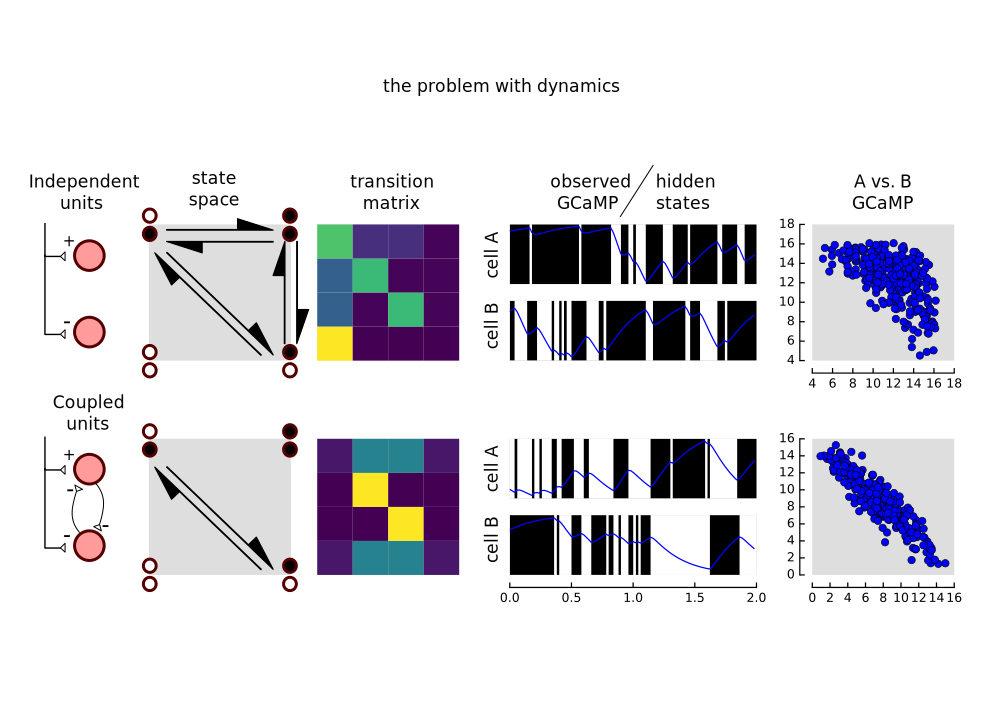

In [914]:
layout = fifi.FigureLayout('prototype_state_model_layout.svg',make_mplfigures = True)

layout.axes['ind_transition'].pcolor(tmtrx_ind[:,::-1].T,cmap = plt.cm.viridis)
layout.axes['coup_transition'].pcolor(tmtrx_coup[:,::-1].T,cmap = plt.cm.viridis)

layout.axes['ind_cell_A'].imshow(cell_A_ind[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)
layout.axes['ind_cell_B'].imshow(cell_B_ind[:,1500:1600],
                                 aspect = 'auto',
                                 interpolation = 'nearest',
                                 cmap = plt.cm.binary)

layout.axes['coup_cell_A'].imshow(cell_A_coup[:,1500:1600],
                                  aspect = 'auto',
                                  interpolation = 'nearest',
                                  cmap = plt.cm.binary)
layout.axes['coup_cell_B'].imshow(cell_B_coup[:,1500:1600],
                                  aspect = 'auto',
                                  interpolation = 'nearest',
                                  cmap = plt.cm.binary)


layout.axes['ind_cell_A'].set_zorder(-10)
layout.axes['ind_cell_B'].set_zorder(-10)

layout.axes['coup_cell_A'].set_zorder(-10)
layout.axes['coup_cell_B'].set_zorder(-10)

layout.axes['ind_cell_A_ts'].plot(times[1500:1600]-times[1500],cell_A_ind_F[1500:1600])
layout.axes['ind_cell_B_ts'].plot(times[1500:1600]-times[1500],cell_B_ind_F[1500:1600])

layout.axes['coup_cell_A_ts'].plot(times[1500:1600]-times[1500],cell_A_coup_F[1500:1600])
layout.axes['coup_cell_B_ts'].plot(times[1500:1600]-times[1500],cell_B_coup_F[1500:1600])

layout.axes['ind_cell_A_ts'].patch.set_facecolor('None')
layout.axes['ind_cell_B_ts'].patch.set_facecolor('None')

layout.axes['coup_cell_A_ts'].patch.set_facecolor('None')
layout.axes['coup_cell_B_ts'].patch.set_facecolor('None')

layout.axes['ind_GCaMP_state'].plot(cell_A_ind_F[1000:-5000:10],cell_B_ind_F[1000:-5000:10],'o',alpha = 0.2)
layout.axes['coup_GCaMP_state'].plot(cell_A_coup_F[1000:-5000:10],cell_B_coup_F[1000:-5000:10],'o',alpha = 0.2)

arrow_params = dict(shape = 'right',width = 0.01,length_includes_head = True,facecolor = 'k',clip_on = False)
layout.axes['ind_state'].arrow(1.1,0.1,0,0.9,**arrow_params)
layout.axes['ind_state'].arrow(1.2,1.0,0,-0.9,**arrow_params)

layout.axes['ind_state'].arrow(1,1,-0.9,0,**arrow_params)
layout.axes['ind_state'].arrow(0.1,1.1,0.9,0,**arrow_params)

layout.axes['ind_state'].arrow(0.9,0.0,-0.9,0.9,**arrow_params)
layout.axes['ind_state'].arrow(0.1,0.9,0.9,-0.9,**arrow_params)

layout.axes['coup_state'].arrow(0.9,0,-0.9,0.9,**arrow_params)
layout.axes['coup_state'].arrow(0.1,0.9,0.9,-0.9,**arrow_params)

layout.axes['ind_state'].set_xbound(-0.05,1.15)
layout.axes['ind_state'].set_ybound(-0.05,1.15)
layout.axes['coup_state'].set_xbound(-0.05,1.15)
layout.axes['coup_state'].set_ybound(-0.05,1.15)

fifi.mpl_functions.set_spines(layout)
layout.save('prototpye_state_model.svg')
plt.close('all')
display(SVG('prototpye_state_model.svg'))

In [915]:
decon_fly = flb.NetFly(1530,rootpath='/media/imager/FlyDataD/FlyDB/')
decon_fly.open_signals()

abf_sp = decon_fly.abf_times[1] #abf spike period
ca_frame_in_abf = np.int(0.02/abf_sp) #abf period in abf idxs

#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(decon_fly.abf_led_pulse)>1.0)[0]
start = ep_idx[0]+np.int(1.5*ca_frame_in_abf) #the calcium data starts at the end of one trigger period 
stop = ep_idx[-1]+np.int(1.5*ca_frame_in_abf)

#make a time array for the recording epoch
ep_times = np.array(decon_fly.abf_times[start:stop])
ep_times -= ep_times[0]

#load this into memory since I will use it quite a bit
i1_spike_sig = np.array(decon_fly.abf_electrode[start:stop])
i1_ca = decon_fly.ca_camera_left_model_fits['i1']

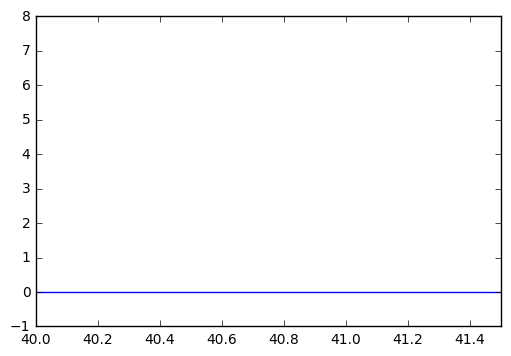

In [928]:
#plt.plot(ep_times,i1_spike_sig*-1 >2)
sig = (i1_spike_sig*-1 >2).astype(float)
plt.plot(scipy.signal.fftconvolve(i1_spike_sig*-1 >2,slow_kernel))
plt.gca().set_xbound(40,41.5)

In [ ]:
scipy.signal